# Library Imports / Setup

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# change current working directory
import os
os.chdir('/content/drive/My Drive/Final Project (NLP)')
os.getcwd()

'/content/drive/My Drive/Final Project (NLP)'

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
import random
import pandas as pd
from ast import literal_eval
import gc
import time
import string
import nltk
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.1.0-rc1


In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
!pip install skll

     |████████████████████████████████| 92kB 2.0MB/s 
     |████████████████████████████████| 133kB 6.1MB/s 
     |████████████████████████████████| 552kB 9.7MB/s 
  Created wheel for skll: filename=skll-2.0-py2.py3-none-any.whl size=103437 sha256=31d6e784e5234ca898a3832c5fa260ca240e80aea8a8d3ccdd3e49ca79602acb
  Stored in directory: /root/.cache/pip/wheels/b4/52/a9/86c4029267f506d435c63f6278d65452564a07c97b59368d5f
Successfully built skll


In [0]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, LSTM, Flatten, Input, Dropout, SimpleRNN
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import cohen_kappa_score
from skll.metrics import kappa
from scipy.stats import spearmanr

In [0]:
# seed for randoom number generator
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)
seed_everything(6000)

# Data Helper Functions

In [0]:
class Data:
    def __init__(self, df, useStopWord, model, dim, test_size):
        self.df = df
        self.useStopWord = useStopWord
        self.model = model
        self.dim = dim
        self.test_size = test_size

    # returns embeddings matrix to be used for Embedding Layer
    def getEmbeddingMatrix(self, tokenizer_obj):
        word_index_dict = tokenizer_obj.word_index
        vocab_size = len(word_index_dict) + 1
        embedding_matrix = np.zeros((vocab_size, self.dim))
        for word, i in word_index_dict.items():
            embedding_vector = self.model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        return embedding_matrix

    # returns main feature vector for all essays - also returns embedding matrix
    def getAllFeatureVec(self, all_essays_tokens):
        tokenizer_obj = Tokenizer()
        tokenizer_obj.fit_on_texts(all_essays_tokens)
        sequences = tokenizer_obj.texts_to_sequences(all_essays_tokens)
        embedding_matrix = self.getEmbeddingMatrix(tokenizer_obj)
        all_feature_vec = np.array(pad_sequences(sequences, maxlen=max([len(seq) for seq in sequences]), padding='post'))
        return all_feature_vec, embedding_matrix

    # returns average feature vector for all essays
    def getAllAvgFeatureVec(self, all_essays_tokens):
        counter = 0
        all_feature_vec = np.zeros((len(all_essays_tokens), self.dim), dtype='float32')
        for essay_tokens in all_essays_tokens:
            average_vec = np.zeros((self.dim,), dtype='float32')
            num_words = 0.
            for word in essay_tokens:
                if word in self.model.wv.vocab:
                    average_vec = np.add(average_vec, self.model.wv[word])
                    num_words += 1.
            if num_words != 0.:
                average_vec = np.divide(average_vec, num_words)
            all_feature_vec[counter] = average_vec
            counter += 1
        return all_feature_vec

    # returns train and test split
    def getTrainTestSplit(self, isTokenizer):
        splits_dict = {}
        if self.useStopWord == True:
            all_essays_tokens = self.df['essay_tokenized_SW']
        else:
            all_essays_tokens = self.df['essay_tokenized_noSW']
        if isTokenizer:
            X, embedding_matrix = self.getAllFeatureVec(all_essays_tokens)
            print('Shape of Embedding Matrix:', embedding_matrix.shape)
        else:
            X = self.getAllAvgFeatureVec(all_essays_tokens)
        Y = self.df['scaled_target_score'].values
        SCORE_INFO = self.df[['essay_set', 'target_score', 'scaled_target_score']]
        train_x, test_x, train_y, test_y, train_score_info, test_score_info = train_test_split(X, Y, SCORE_INFO, test_size=self.test_size, random_state=42)
        print('Shape of TRAIN X:', train_x.shape)
        print('Shape of TEST X: ', test_x.shape)
        print('Shape of TRAIN Y:', train_y.shape)
        print('Shape of TEST Y: ', test_y.shape)
        print('Shape of TRAIN SCORE INFO:', train_score_info.shape)
        print('Shape of TEST SCORE INFO: ', test_score_info.shape)
        splits_dict = {'train_x':train_x, 'test_x':test_x, 
                       'train_y':train_y, 'test_y':test_y, 
                       'train_score_info':train_score_info, 'test_score_info':test_score_info}
        if isTokenizer:
            splits_dict['embedding_matrix'] = embedding_matrix
        return splits_dict

In [0]:
# scales original target scores to specific range based on essay set
def getScaledScores(df, score_range):
    scaled_scores = []
    scaler = MinMaxScaler(feature_range=score_range)
    for topic_number in range(1, 9):
        topic_target_scores = df[df['essay_set'] == topic_number]['target_score'].to_frame()
        scaled_topic_target_scores = (scaler.fit_transform(topic_target_scores).reshape(-1))
        scaled_scores = np.append(scaled_scores, scaled_topic_target_scores)
    return scaled_scores

# Load Main Train Data File

In [0]:
# load cleaned train essay file
df = pd.read_csv('./DATA/clean_train.csv', index_col=False)
# convert string column back to lists type
df[['essay_tokenized_noSW', 'essay_tokenized_SW']] = df[['essay_tokenized_noSW', 'essay_tokenized_SW']].applymap(literal_eval)
# scale target scores to range (0, 1)
df['scaled_target_score'] = getScaledScores(df, score_range=(0, 1))
print('Shape of Dataframe:', df.shape)
df.head(10)

Shape of Dataframe: (12976, 10)


,essay_set,essay,rater1_domain1,rater2_domain1,target_score,essay_clean_noSW,essay_clean_SW,essay_tokenized_noSW,essay_tokenized_SW,scaled_target_score
0,1,"Dear local newspaper, I think effects computer...",4,4,8,"dear local newspaper, think effects computers ...","dear local newspaper, i think effects computer...","[dear, local, newspaper, think, effects, compu...","[dear, local, newspaper, i, think, effects, co...",0.6
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,"dear label_caps label_caps, believe using comp...","dear label_caps label_caps, i believe that usi...","[dear, labelcaps, labelcaps, believe, using, c...","[dear, labelcaps, labelcaps, i, believe, that,...",0.7
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,"dear, label_caps label_caps label_caps people ...","dear, label_caps label_caps label_caps more an...","[dear, labelcaps, labelcaps, labelcaps, people...","[dear, labelcaps, labelcaps, labelcaps, more, ...",0.5
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,"dear local newspaper, label_caps found many ex...","dear local newspaper, label_caps i have found ...","[dear, local, newspaper, labelcaps, found, man...","[dear, local, newspaper, labelcaps, i, have, f...",0.8
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,"dear label_location, know computers positive e...","dear label_location, i know having computers h...","[dear, labellocation, know, computers, positiv...","[dear, labellocation, i, know, having, compute...",0.6
5,1,"Dear @LOCATION1, I think that computers have a...",4,4,8,"dear label_location, think computers negative ...","dear label_location, i think that computers ha...","[dear, labellocation, think, computers, negati...","[dear, labellocation, i, think, that, computer...",0.6
6,1,Did you know that more and more people these d...,5,5,10,"know people days depending computers safety, n...",did you know that more and more people these d...,"[know, people, days, depending, computers, saf...","[did, you, know, that, more, and, more, people...",0.8
7,1,@PERCENT1 of people agree that computers make ...,5,5,10,label_percent people agree computers make life...,label_percent of people agree that computers m...,"[labelpercent, people, agree, computers, make,...","[labelpercent, of, people, agree, that, comput...",0.8
8,1,"Dear reader, @ORGANIZATION1 has had a dramatic...",4,5,9,"dear reader, label_organization dramatic effec...","dear reader, label_organization has had a dram...","[dear, reader, labelorganization, dramatic, ef...","[dear, reader, labelorganization, has, had, a,...",0.7
9,1,In the @LOCATION1 we have the technology of a ...,5,4,9,label_location technology computer. say comput...,in the label_location we have the technology o...,"[labellocation, technology, computer, say, com...","[in, the, labellocation, we, have, the, techno...",0.7


# Model Functions

In [0]:
# returns fitted model along with history object
def fitModel(model, data, batch_size, epochs, val_size, verbose, callbacks_list):
    start = time.time()
    history = model.fit(data['train_x'], data['train_y'], batch_size=batch_size, epochs=epochs, 
                        validation_split=val_size, verbose=verbose, callbacks=callbacks_list)
    end = time.time() - start
    print('\n\tTotal Training Time:', np.round(end, 2), 'seconds')
    print('Train Loss:', np.round(np.mean(history.history['loss']), 4))
    print('Val   Loss:', np.round(np.mean(history.history['val_loss']), 4))
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], 'r--', label='train_loss')
    plt.plot(history.history['val_loss'], 'b-', label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Learning Curve')
    plt.legend(loc='best')
    plt.show()
    return history, model

In [0]:
def calculate_kappa_score(results_df):
    kappa_list = []
    for topic_number in range(1, 8):
        kappa_list.append(kappa(results_df[results_df.essay_set == topic_number]['target_score'], 
                                results_df[results_df.essay_set == topic_number]['rescaled_y_pred'], 
                                weights='quadratic'))
    print(np.round(kappa_list, 4))
    return np.mean(kappa_list)

In [0]:
def scalePred(results_df):
    score_range_df = results_df.groupby('essay_set')['target_score'].agg(['min', 'max'])
    score_ranges = list(zip(score_range_df['min'], score_range_df['max']))
    rescaled_y_pred_arr = []
    for topic_number in range(1, 9):
        scaler = MinMaxScaler(score_ranges[topic_number - 1])
        rescaled_y_pred = scaler.fit_transform(results_df[results_df['essay_set'] == topic_number]['y_pred'].to_frame()).round(0).astype('int')
        rescaled_y_pred_arr = np.append(rescaled_y_pred_arr, rescaled_y_pred)
    results_df['rescaled_y_pred'] = rescaled_y_pred_arr
    return results_df

In [0]:
def evaluateModel(model, data):
    y_pred = pd.DataFrame(model.predict(data['test_x']).reshape(-1))
    results = data['test_score_info'].reset_index(drop=True).join(y_pred).rename(columns={0:'y_pred'}).sort_values(by='essay_set').reset_index(drop=True)
    results = scalePred(results)
    print('Test Quadratic Cohen Kappa Score:', np.round(calculate_kappa_score(results), 4))
    return results

# Draft NN Model

In [0]:
nosw_50_model = Word2Vec.load('./DATA/custom_word2vec_models/50_noSW_word2vec_model')
nosw_50_data = Data(df=df, useStopWord=False, model=nosw_50_model, dim=50, test_size=0.1).getTrainTestSplit()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 50)
Shape of TEST X:  (1298, 50)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)


In [0]:
model = Sequential()
model.add(Dense(25, activation='relu', input_dim=50))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


Train on 10510 samples, validate on 1168 samples
Epoch 1/100
10510/10510 [==============================] - 1s 77us/sample - loss: 0.0603 - val_loss: 0.0597
Epoch 2/100
10510/10510 [==============================] - 0s 15us/sample - loss: 0.0566 - val_loss: 0.0593
Epoch 3/100
10510/10510 [==============================] - 0s 15us/sample - loss: 0.0564 - val_loss: 0.0594
Epoch 4/100
10510/10510 [==============================] - 0s 15us/sample - loss: 0.0563 - val_loss: 0.0592
Epoch 5/100
10510/10510 [==============================] - 0s 15us/sample - loss: 0.0562 - val_loss: 0.0591
Epoch 6/100
10510/10510 [==============================] - 0s 16us/sample - loss: 0.0561 - val_loss: 0.0589
Epoch 7/100
10510/10510 [==============================] - 0s 14us/sample - loss: 0.0560 - val_loss: 0.0589
Epoch 8/100
10510/10510 [==============================] - 0s 15us/sample - loss: 0.0558 - val_loss: 0.0587
Epoch 9/100
10510/10510 [==============================] - 0s 15us/sample - loss: 0.055

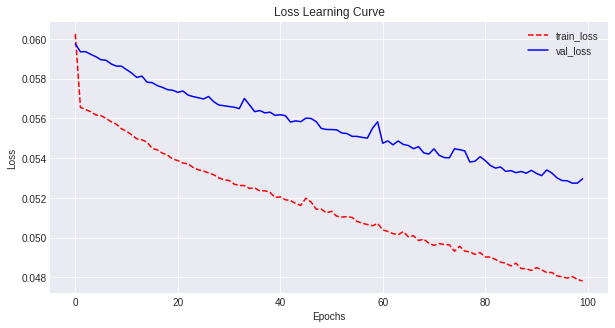

In [0]:
history, model = fitModel(model=model, data=nosw_50_data, batch_size=256, epochs=100, val_size=0.1, verbose=1, callbacks_list=None)

In [0]:
results = evaluateModel(model=model, data=nosw_50_data)
results.head(10)

Test Quadratic Cohen Kappa Score: 0.288


,essay_set,target_score,scaled_target_score,y_pred,rescaled_y_pred
0,1,8,0.6,0.613143,10.0
1,1,10,0.8,0.646485,11.0
2,1,11,0.9,0.585725,9.0
3,1,8,0.6,0.610420,10.0
4,1,10,0.8,0.629774,10.0
5,1,8,0.6,0.590465,9.0
6,1,10,0.8,0.678008,12.0
7,1,10,0.8,0.646878,11.0
8,1,7,0.5,0.571512,8.0
9,1,7,0.5,0.659686,11.0


#MLP Trials

In [0]:
def MLP(input_dim, drate, isTrainable):
    model = Sequential(name='mlp')
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
    model.add(Dropout(drate))
    #model.add(Flatten())
    model.add(Dense(units=1,activation='sigmoid', name='output'))
    model.compile(optimizer='adam', loss='mse')
    return model


			Dimension : 50


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 50)
Shape of TEST X:  (1298, 50)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 30.33 seconds
Train Loss: 0.0268
Val   Loss: 0.0302


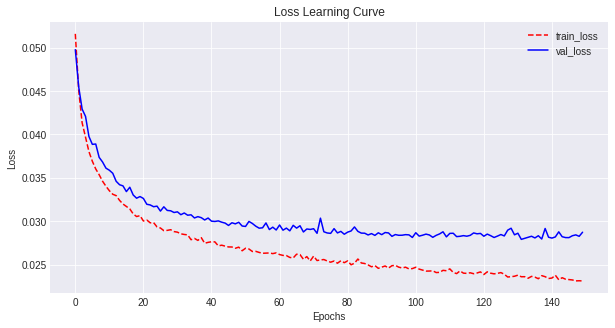

[0.5751 0.5287 0.4977 0.6606 0.6965 0.652  0.6952]
Test Quadratic Cohen Kappa Score: 0.6151

			Dimension : 100


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 100)
Shape of TEST X:  (1298, 100)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 30.62 seconds
Train Loss: 0.0242
Val   Loss: 0.03


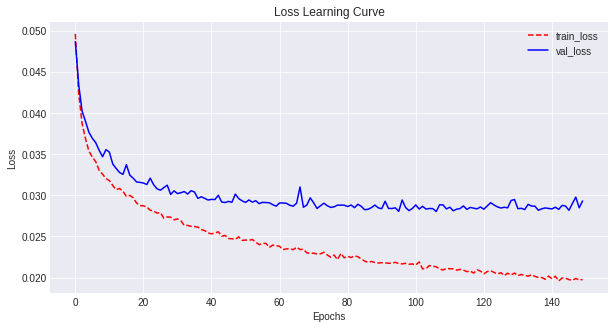

[0.5618 0.491  0.4709 0.6687 0.7185 0.638  0.7502]
Test Quadratic Cohen Kappa Score: 0.6142

			Dimension : 200


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 200)
Shape of TEST X:  (1298, 200)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 30.59 seconds
Train Loss: 0.0222
Val   Loss: 0.0288


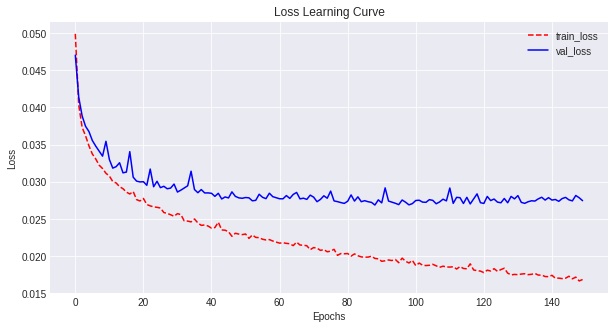

[0.5743 0.517  0.5513 0.7043 0.748  0.6573 0.7195]
Test Quadratic Cohen Kappa Score: 0.6388

			Dimension : 300


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 300)
Shape of TEST X:  (1298, 300)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 30.61 seconds
Train Loss: 0.0225
Val   Loss: 0.0292


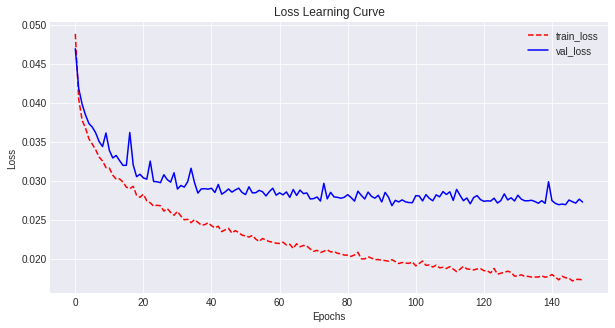

[0.5679 0.4343 0.4694 0.6866 0.7231 0.6684 0.7548]
Test Quadratic Cohen Kappa Score: 0.6149

			Dimension : 500


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 500)
Shape of TEST X:  (1298, 500)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 32.87 seconds
Train Loss: 0.0228
Val   Loss: 0.0298


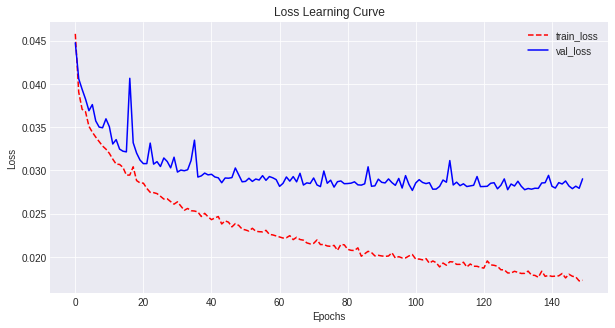

[0.5379 0.4417 0.4831 0.6901 0.7503 0.6775 0.7018]
Test Quadratic Cohen Kappa Score: 0.6118


'\nEpochs:100, Dense:32\n56.9\nDense: 128, Dimension: 200\n60\n'

In [0]:
# test different dimension vectors with cnn model
for dim in [50, 100, 200, 300, 500]:
    print('\n\t\t\tDimension :', dim)
    model = Word2Vec.load('./DATA/custom_word2vec_models/' + str(dim) + '_noSW_word2vec_model')
    data = Data(df=df, useStopWord=False, model=model, dim=dim, test_size=0.1).getTrainTestSplit(isTokenizer=False)
    cnn_model = MLP(data['train_x'].shape[1], drate=0.2, isTrainable=False)
    history, cnn_model = fitModel(model=cnn_model, data=data, batch_size=128, epochs=150, val_size=0.1, verbose=0, callbacks_list=None) 
    results = evaluateModel(model=cnn_model, data=data)
'''
Epochs:100, Dense:32
56.9
Dense: 128, Dimension: 200
60
'''

In [0]:
def MLP_rms(input_dim, drate, isTrainable):
    model = Sequential(name='mlp')
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
    model.add(Dropout(drate))
    #model.add(Flatten())
    model.add(Dense(units=1,activation='sigmoid', name='output'))
    model.compile(optimizer='rmsprop', loss='mse')
    return model


			Dimension : 50


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 50)
Shape of TEST X:  (1298, 50)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 31.76 seconds
Train Loss: 0.0271
Val   Loss: 0.0319


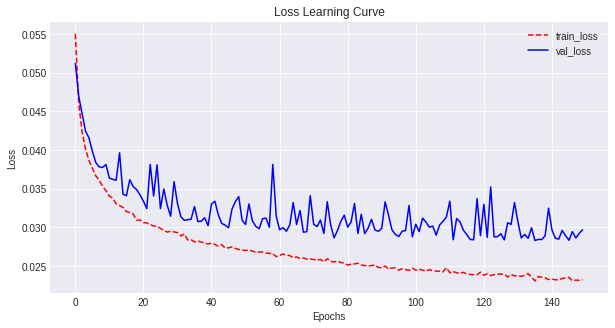

[0.6005 0.5131 0.5315 0.6522 0.7262 0.6999 0.6801]
Test Quadratic Cohen Kappa Score: 0.6291

			Dimension : 100


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 100)
Shape of TEST X:  (1298, 100)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 32.14 seconds
Train Loss: 0.0249
Val   Loss: 0.0321


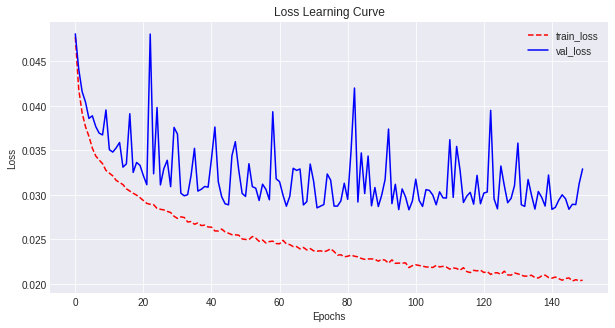

[0.559  0.5205 0.5103 0.6685 0.7135 0.6908 0.7264]
Test Quadratic Cohen Kappa Score: 0.627

			Dimension : 200


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 200)
Shape of TEST X:  (1298, 200)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 32.13 seconds
Train Loss: 0.0233
Val   Loss: 0.0319


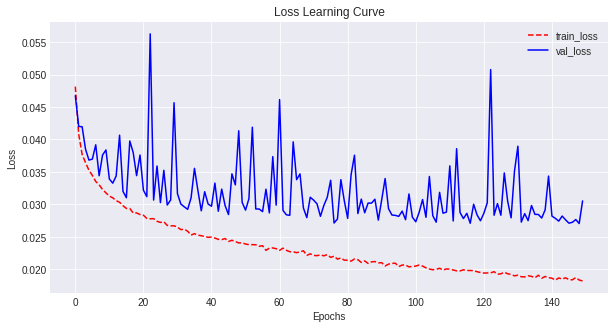

[0.5601 0.5291 0.5176 0.6848 0.752  0.7166 0.7027]
Test Quadratic Cohen Kappa Score: 0.6375

			Dimension : 300


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 300)
Shape of TEST X:  (1298, 300)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 32.37 seconds
Train Loss: 0.024
Val   Loss: 0.0333


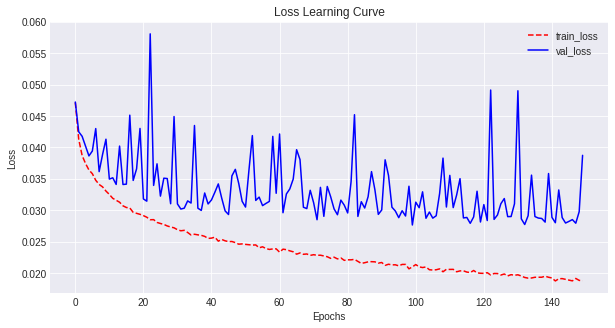

[0.5658 0.4183 0.5322 0.6825 0.7531 0.7442 0.6913]
Test Quadratic Cohen Kappa Score: 0.6268

			Dimension : 500


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 500)
Shape of TEST X:  (1298, 500)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 35.18 seconds
Train Loss: 0.0243
Val   Loss: 0.0347


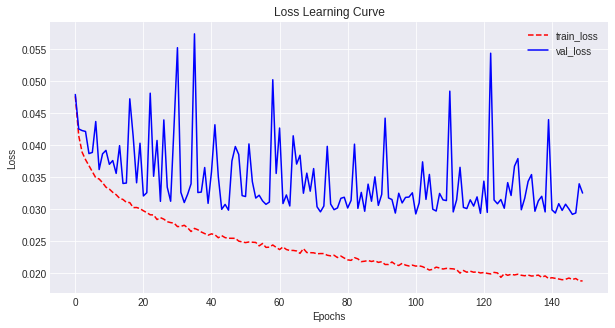

[0.5251 0.4128 0.5049 0.6657 0.7356 0.6223 0.7084]
Test Quadratic Cohen Kappa Score: 0.5964


In [0]:
# test different dimension vectors with cnn model
for dim in [50, 100, 200, 300, 500]:
    print('\n\t\t\tDimension :', dim)
    model = Word2Vec.load('./DATA/custom_word2vec_models/' + str(dim) + '_noSW_word2vec_model')
    data = Data(df=df, useStopWord=False, model=model, dim=dim, test_size=0.1).getTrainTestSplit(isTokenizer=False)
    cnn_model = MLP_rms(data['train_x'].shape[1], drate=0.2, isTrainable=False)
    history, cnn_model = fitModel(model=cnn_model, data=data, batch_size=128, epochs=150, val_size=0.1, verbose=0, callbacks_list=None) 
    results = evaluateModel(model=cnn_model, data=data)

In [0]:
def MLP_sgd(input_dim, drate, isTrainable):
    model = Sequential(name='mlp')
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
    model.add(Dropout(drate))
    #model.add(Flatten())
    model.add(Dense(units=1,activation='sigmoid', name='output'))
    model.compile(optimizer='sgd', loss='mse')
    return model


			Dimension : 50


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 50)
Shape of TEST X:  (1298, 50)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 38.54 seconds
Train Loss: 0.0491
Val   Loss: 0.0526


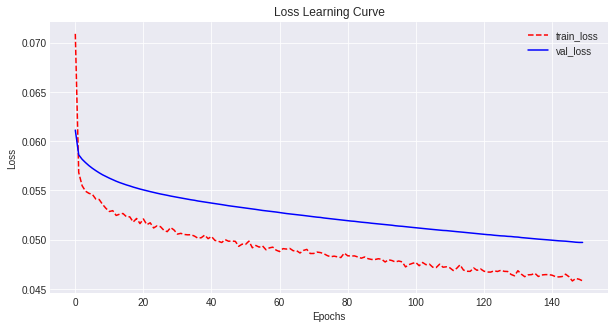

[0.46   0.2253 0.2315 0.3935 0.3214 0.4735 0.3624]
Test Quadratic Cohen Kappa Score: 0.3525

			Dimension : 100


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 100)
Shape of TEST X:  (1298, 100)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 37.85 seconds
Train Loss: 0.0493
Val   Loss: 0.0533


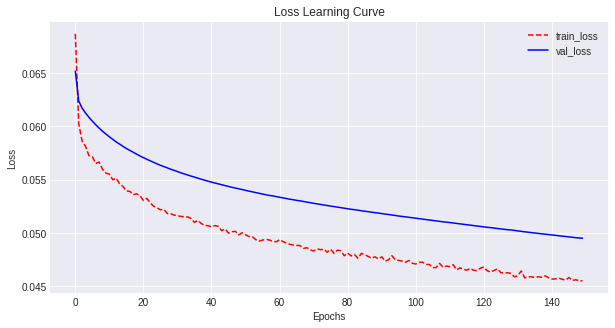

[0.3737 0.3022 0.3782 0.3747 0.3972 0.4248 0.5869]
Test Quadratic Cohen Kappa Score: 0.4054

			Dimension : 200


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 200)
Shape of TEST X:  (1298, 200)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 38.52 seconds
Train Loss: 0.0488
Val   Loss: 0.0533


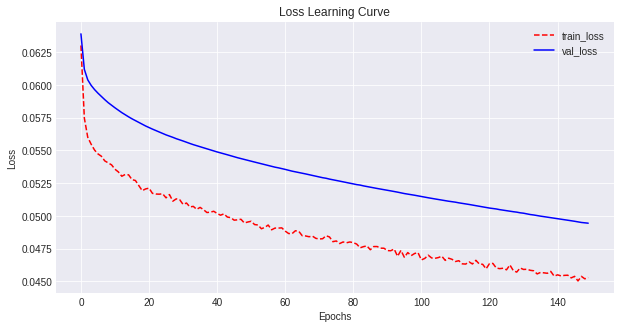

[0.4348 0.2685 0.3252 0.3764 0.4207 0.4472 0.6273]
Test Quadratic Cohen Kappa Score: 0.4143

			Dimension : 300


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 300)
Shape of TEST X:  (1298, 300)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)

	Total Training Time: 39.1 seconds
Train Loss: 0.0486
Val   Loss: 0.0532


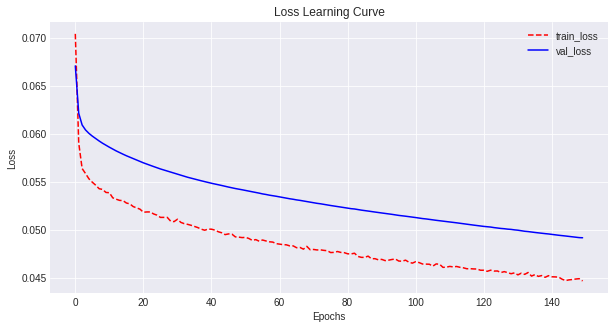

[0.4217 0.3235 0.3345 0.4414 0.4317 0.4942 0.5895]
Test Quadratic Cohen Kappa Score: 0.4338

			Dimension : 500


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 500)
Shape of TEST X:  (1298, 500)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)


In [0]:
# test different dimension vectors with cnn model
for dim in [50, 100, 200, 300, 500]:
    print('\n\t\t\tDimension :', dim)
    model = Word2Vec.load('./DATA/custom_word2vec_models/' + str(dim) + '_noSW_word2vec_model')
    data = Data(df=df, useStopWord=False, model=model, dim=dim, test_size=0.1).getTrainTestSplit(isTokenizer=False)
    cnn_model = MLP_sgd(data['train_x'].shape[1], drate=0.2, isTrainable=False)
    history, cnn_model = fitModel(model=cnn_model, data=data, batch_size=128, epochs=150, val_size=0.1, verbose=0, callbacks_list=None) 
    results = evaluateModel(model=cnn_model, data=data)